In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from pathlib import Path
import random
import os
from PIL import Image

Nom du fichier : 22_1_3_20170105002553629.jpg.chip.jpg
Femme de 22 ans


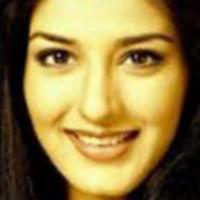

In [2]:
imgdir = Path('Age estimation/utkcropped/')
img = random.choice(os.listdir(imgdir))
print(f"Nom du fichier : {img}")
if img.split('_')[1] == '1':
      print(f"Femme de {img.split('_')[0]} ans")
elif img.split('_')[1] == '0':
      print(f"Homme de {img.split('_')[0]} ans")
else:
      print("Error")

image = Image.open('Age estimation/utkcropped/' + img)
image # Size=200x200

In [3]:
df = pd.DataFrame(columns=['Label','Fichier'])

imgdir = Path('Age estimation/utkcropped/')
for indice, fichier in enumerate(os.listdir(imgdir)):
    if '.jpg.chip.jpg' in fichier:
        abs_path = f'Age estimation/utkcropped/{fichier}' 
        df = df.append({'Fichier': abs_path, 'Label': fichier.split('_')[0]}, ignore_index=True)
        print(indice, fichier.split('_')[0], fichier, abs_path)
            
print(df.shape)
print(df.dtypes)
df.head(10)

0 100 100_0_0_20170112213500903.jpg.chip.jpg Age estimation/utkcropped/100_0_0_20170112213500903.jpg.chip.jpg
1 100 100_0_0_20170112215240346.jpg.chip.jpg Age estimation/utkcropped/100_0_0_20170112215240346.jpg.chip.jpg
2 100 100_1_0_20170110183726390.jpg.chip.jpg Age estimation/utkcropped/100_1_0_20170110183726390.jpg.chip.jpg
3 100 100_1_0_20170112213001988.jpg.chip.jpg Age estimation/utkcropped/100_1_0_20170112213001988.jpg.chip.jpg
4 100 100_1_0_20170112213303693.jpg.chip.jpg Age estimation/utkcropped/100_1_0_20170112213303693.jpg.chip.jpg
5 100 100_1_0_20170112215032192.jpg.chip.jpg Age estimation/utkcropped/100_1_0_20170112215032192.jpg.chip.jpg
6 100 100_1_0_20170117195420803.jpg.chip.jpg Age estimation/utkcropped/100_1_0_20170117195420803.jpg.chip.jpg
7 100 100_1_0_20170119212053665.jpg.chip.jpg Age estimation/utkcropped/100_1_0_20170119212053665.jpg.chip.jpg
8 100 100_1_2_20170105174847679.jpg.chip.jpg Age estimation/utkcropped/100_1_2_20170105174847679.jpg.chip.jpg
9 100 100_

,Label,Fichier
0,100,Age estimation/utkcropped/100_0_0_201701122135...
1,100,Age estimation/utkcropped/100_0_0_201701122152...
2,100,Age estimation/utkcropped/100_1_0_201701101837...
3,100,Age estimation/utkcropped/100_1_0_201701122130...
4,100,Age estimation/utkcropped/100_1_0_201701122133...
5,100,Age estimation/utkcropped/100_1_0_201701122150...
6,100,Age estimation/utkcropped/100_1_0_201701171954...
7,100,Age estimation/utkcropped/100_1_0_201701192120...
8,100,Age estimation/utkcropped/100_1_2_201701051748...
9,100,Age estimation/utkcropped/100_1_2_201701122136...


In [4]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.1, random_state=0)

print(f'Shape :\ndf_train : {df_train.shape}\ndf_test : {df_test.shape}')

Shape :
df_train : (21337, 2)
df_test : (2371, 2)


In [5]:
from keras.preprocessing.image import ImageDataGenerator

height=200 # images ont des tailles différentes donc on prend 150x150 pixels
width=200
channel=3
batch_size = 64

# Training generator
train_datagen = ImageDataGenerator(rescale=1./255, # Multiply the data by the rescale (after applying all other transformations)
                                   rotation_range=10, # Degree range for random rotations
                                   width_shift_range=0.2, # Fraction of total width
                                   height_shift_range=0.2, # Fraction of total height
                                   shear_range=0.2, # Shear Intensity
                                   zoom_range=0.2, # Range for random zoom
                                   horizontal_flip=True, # Randomly flip inputs horizontally
                                   fill_mode='nearest', # Points outside the boundaries of the input are filled according to 'aaaaaaaa|abcd|dddddddd'
                                   validation_split=0.2)

train_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                    directory=None,
                                                    x_col="Fichier",
                                                    y_col="Label",
                                                    target_size=(height,width), # Size to resize images
                                                    batch_size=batch_size,
                                                    seed=1337,
                                                    shuffle=True,
                                                    class_mode='sparse',
                                                    subset='training')

validation_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                         directory=None,
                                                         x_col="Fichier",
                                                         y_col="Label",
                                                         target_size=(height,width), # Size to resize images
                                                         batch_size=batch_size,
                                                         seed=1337,
                                                         shuffle=True,
                                                         class_mode='sparse',
                                                         subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(dataframe=df_test,
                                                  directory=None,
                                                  x_col="Fichier",
                                                  y_col="Label",
                                                  target_size=(height,width), # Size to resize images
                                                  batch_size=batch_size,
                                                  seed=1337,
                                                  shuffle=False,
                                                  class_mode='sparse')

train_num = train_generator.samples
validation_num = validation_generator.samples
test_num = test_generator.samples

Using TensorFlow backend.


Found 17070 validated image filenames belonging to 104 classes.
Found 4267 validated image filenames belonging to 104 classes.
Found 2371 validated image filenames belonging to 94 classes.


64.0


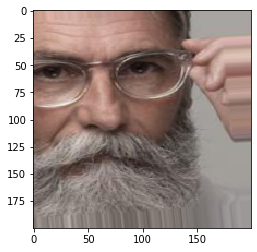

In [6]:
print(train_generator[0][1][1])
plt.imshow(train_generator[0][0][1])

In [8]:
model = keras.Sequential([
                          keras.layers.Conv2D(64, 7, activation='relu', padding='same', input_shape=(height,width,channel)),
                          keras.layers.MaxPooling2D(2),    
                          keras.layers.Conv2D(128, 7, activation='relu', padding='same', input_shape=(height,width,channel)),
                          keras.layers.MaxPooling2D(2),
                          keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
                          #keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
                          keras.layers.MaxPooling2D(2),

                          keras.layers.Flatten(),
                          keras.layers.Dense(512, activation='relu'),
                          keras.layers.Dropout(0.5),                          
                          keras.layers.Dense(1)
])

model.compile(loss='mse',
              optimizer='adam',
              metrics=['mae'])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_mae',
                                               patience=3, 
                                               restore_best_weights=True)

history = model.fit_generator(train_generator,
                              steps_per_epoch= train_num // batch_size,
                              epochs=200,
                              validation_data=validation_generator,
                              validation_steps= validation_num // batch_size,
                              callbacks=[early_stopping]) # 12.4972

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 266 steps, validate for 66 steps
Epoch 1/200
266/266 [==============================] - 9380s 35s/step - loss: 535.6319 - mae: 17.5747 - val_loss: 466.3269 - val_mae: 17.3605
Epoch 2/200
266/266 [==============================] - 9859s 37s/step - loss: 463.1535 - mae: 16.7924 - val_loss: 458.0907 - val_mae: 16.5058
Epoch 3/200
124/266 [============>.................] - ETA: 1:06:28 - loss: 467.6547 - mae: 16.8963

KeyboardInterrupt: 

In [88]:
model.evaluate_generator(test_generator, test_generator.samples) # mae : 11.154201

  ...
    to  
  ['...']


[3.735325639934693, 11.154201]

Transfert Learning

In [91]:
from keras.preprocessing.image import ImageDataGenerator

height=224 # images ont des tailles différentes donc on prend 150x150 pixels
width=224
channel=3
batch_size = 64

# Training generator
train_datagen = ImageDataGenerator(preprocessing_function=keras.applications.vgg19.preprocess_input, validation_split=0.2)


train_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                    directory=None,
                                                    x_col="Fichier",
                                                    y_col="Label",
                                                    target_size=(height,width), # Size to resize images
                                                    batch_size=batch_size,
                                                    seed=1337,
                                                    shuffle=True,
                                                    class_mode='sparse',
                                                    subset='training')

validation_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                                         directory=None,
                                                         x_col="Fichier",
                                                         y_col="Label",
                                                         target_size=(height,width), # Size to resize images
                                                         batch_size=batch_size,
                                                         seed=1337,
                                                         shuffle=True,
                                                         class_mode='sparse',
                                                         subset='validation')

test_generator = ImageDataGenerator(preprocessing_function=keras.applications.vgg19.preprocess_input)

test_generator = test_datagen.flow_from_dataframe(dataframe=df_test,
                                                  directory=None,
                                                  x_col="Fichier",
                                                  y_col="Label",
                                                  target_size=(height,width), # Size to resize images
                                                  batch_size=batch_size,
                                                  seed=1337,
                                                  shuffle=False,
                                                  class_mode='sparse')

train_num = train_generator.samples
validation_num = validation_generator.samples
test_num = test_generator.samples

Found 17070 validated image filenames belonging to 104 classes.
Found 4267 validated image filenames belonging to 104 classes.
Found 2371 validated image filenames belonging to 94 classes.


In [92]:
# Lien Kaggle : https://www.kaggle.com/madz2000/flowers-classification-using-vgg19-87-accuracy

pre_trained_model = keras.applications.VGG19(input_shape=(224,224,3),
                                             include_top=False,
                                             weights="imagenet")

for layer in pre_trained_model.layers[:19]: #There are 19 layers in VGG19 model. So I freezed the weights of the first 18 layers except for the last layer so that they don't get updated during backpropagation.
    layer.trainable = False

model = keras.models.Sequential([pre_trained_model,
                                 keras.layers.MaxPool2D((2,2) , strides = 2),
                                 keras.layers.Flatten(),
                                 keras.layers.Dense(1)])

model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001),
              loss = 'mean_squared_error',
              metrics = ['mae'])

learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_mae',
                                                            patience = 2,
                                                            verbose=1,
                                                            factor=0.1,
                                                            min_lr=0.00001)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_mae',
                                               patience=3, 
                                               restore_best_weights=True)

history = model.fit_generator(train_generator,
                              steps_per_epoch= train_num // batch_size,
                              epochs=25,
                              validation_data=validation_generator,
                              validation_steps= validation_num // batch_size,
                              callbacks=[early_stopping,learning_rate_reduction]) # 12.4972 -->

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 266 steps, validate for 66 steps
Epoch 1/25
266/266 [==============================] - 11040s 42s/step - loss: 1255.5098 - mae: 17.2355 - val_loss: 352.0222 - val_mae: 13.7007
Epoch 2/25
266/266 [==============================] - 10091s 38s/step - loss: 318.0292 - mae: 13.1937 - val_loss: 303.2675 - val_mae: 12.9387
Epoch 3/25
266/266 [==============================] - 10109s 38s/step - loss: 281.2757 - mae: 12.3130 - val_loss: 289.2267 - val_mae: 12.3358
Epoch 4/25
266/266 [==============================] - 11840s 45s/step - loss: 254.8046 - mae: 11.6858 - val_loss: 287.0100 - val_mae: 12.5002
Epoch 5/25
266/266 [==============================] - 10042s 38s/step - loss: 231.2942 - mae: 11.1473 - val_loss: 290.2325 - val_mae: 12.3041
Epoch 6/25
266/266 [==============================] - 9731s 37s/step - loss: 208.9179 - mae: 10.5982 - val_loss: 300.5160 - val_mae: 12.8793
Epoch 7/25
265/266 [============================>.] - E

In [93]:
model.evaluate_generator(test_generator, test_generator.samples) # MAE : 11.154201 --> 31.346544

  ...
    to  
  ['...']


[22.72330258939398, 31.346544]